In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.io as sio
import pprint as pp
import numpy as np
import seaborn as sns
import pandas as pd
import os
import re
import gc
# pre
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
# Study
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
import matplotlib as mpl
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
from time import time
from scipy import stats

# helpers files
import infoStructure as ins
import helpers as hp
import display as dp
import clustering as cl
import importlib #importlib.reload(foo)

In [2]:
FEATHDir = '/sanssauvegarde/homes/v18porti/info/'
BIGDir = '/media/v18porti/ADATA SH14/stg/Brest/'
MDIR = FEATHDir

### Get saved DataFrame

In [3]:
df_ALL = pd.read_feather(MDIR + '200_32.feather') #100, 300, 10
#dp.printScatter(principalDf['pc1'], principalDf['pc2'])

In [4]:
df_ALL.describe()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
count,5.035840e+07,5.035947e+07,5.035947e+07,4.943770e+07
mean,2.868624e+14,1.002450e+02,1.832059e+14,1.364339e+01
std,inf,3.779417e+03,inf,3.970723e+01
min,-1.196758e+01,0.000000e+00,-1.520206e+00,0.000000e+00
25%,8.376141e+00,3.713027e+00,1.080568e+01,4.991102e+00
50%,1.086889e+01,5.205714e+00,1.434603e+01,7.447418e+00
75%,1.583047e+01,7.720136e+00,2.120557e+01,1.173964e+01
max,3.421422e+19,8.780618e+05,2.250281e+20,1.712306e+03


In [5]:
df_ALL.corr()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
vectorRRKLD_ALL,1.000000,0.022458,-0.000004,0.001825
vectorFAmpKLD_ALL,0.022458,1.000000,0.002293,0.008832
vectorUFAmpKLD_ALL,-0.000004,0.002293,1.000000,0.043894
vectorCorrKLD_ALL,0.001825,0.008832,0.043894,1.000000


In [6]:
df_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50359472 entries, 0 to 50359471
Data columns (total 4 columns):
vectorRRKLD_ALL       float32
vectorFAmpKLD_ALL     float32
vectorUFAmpKLD_ALL    float32
vectorCorrKLD_ALL     float32
dtypes: float32(4)
memory usage: 768.4 MB


# Outliers

## Prepare Data

In [7]:
len(df_ALL) - df_ALL.count()

vectorRRKLD_ALL         1069
vectorFAmpKLD_ALL          0
vectorUFAmpKLD_ALL         0
vectorCorrKLD_ALL     921773
dtype: int64

In [8]:
df_ALL

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
0,14.824769,3.782338,5.010150,0.155980
1,15.162229,3.555532,4.936006,0.182778
2,15.026611,3.573871,5.059862,0.182778
3,14.735096,3.568545,5.038576,0.182777
4,14.735096,3.568545,5.038576,0.182777
5,14.735096,3.568545,5.038576,0.182777
6,13.762024,3.538424,5.014719,0.182778
7,13.762024,3.538424,5.014719,0.182778
8,13.316245,3.341414,5.034057,0.163617
9,12.728650,3.333261,5.036769,0.186373


In [9]:
num_attribs = list(df_ALL)

pipeline = Pipeline([
        ('selector', hp.DataFrameSelector(num_attribs)), # to handle pandas data frame
        ('imputer', Imputer(strategy="median")), # fill missing values with median
    ])

data_prepared = pipeline.fit_transform(df_ALL)
del pipeline

In [10]:
df_prepare = hp.convertDictInDF(hp.putDataInDict(
        [data_prepared[:,0], data_prepared[:,1], data_prepared[:,2], data_prepared[:,3]],
        ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD']
    ))
del data_prepared
df_prepare.describe()

,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
count,5.035947e+07,5.035947e+07,5.035947e+07,5.035947e+07
mean,2.868563e+14,1.002450e+02,1.832059e+14,1.352998e+01
std,inf,3.779417e+03,inf,3.935092e+01
min,-1.196758e+01,0.000000e+00,-1.520206e+00,0.000000e+00
25%,8.376195e+00,3.713027e+00,1.080568e+01,5.036375e+00
50%,1.086889e+01,5.205714e+00,1.434603e+01,7.447418e+00
75%,1.583030e+01,7.720136e+00,2.120557e+01,1.160902e+01
max,3.421422e+19,8.780618e+05,2.250281e+20,1.712306e+03


In [11]:
df_prepare.shape

(50359472, 4)

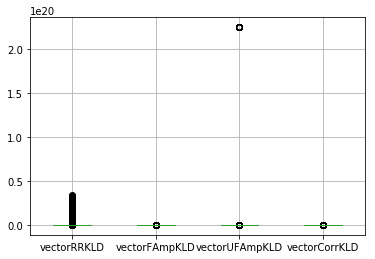

In [14]:
df_prepare.boxplot()

In [15]:
plt.clf()
plt.close()

## Take out outliers 

> threshold = 100 ( zscore )

In [12]:
df_o = df_prepare.copy()
del df_prepare, df_ALL
gc.collect()
threshold = 100

In [13]:
z = np.abs(stats.zscore(df_o['vectorCorrKLD']))
print(np.where(z > threshold))
df_o3 = df_o.copy()
df_o3 = df_o3[(z <= threshold)]
print(df_o3.shape)

(array([], dtype=int64),)
(50359472, 4)


In [14]:
z = np.abs(stats.zscore(df_o3['vectorRRKLD']))
print(np.where(z > threshold))
df_o = df_o3.copy()
df_o = df_o[(z <= threshold)]
print(df_o.shape)

/homes/v18porti/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/homes/v18porti/.local/lib/python3.6/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


(array([], dtype=int64),)
(50359472, 4)


In [15]:
z = np.abs(stats.zscore(df_o['vectorFAmpKLD']))
print(np.where(z > threshold))
df_o3 = df_o.copy()
df_o3 = df_o3[(z <= threshold)]
print(df_o3.shape)

(array([18618067, 18618068, 18618069, ..., 18646807, 18646808, 18646809]),)
(50358428, 4)


In [16]:
z = np.abs(stats.zscore(df_o3['vectorUFAmpKLD']))
print(np.where(z > threshold))
df_o = df_o3.copy()
df_o = df_o[(z <= threshold)]
print(df_o.shape)

/homes/v18porti/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


(array([], dtype=int64),)
(50358428, 4)


In [17]:
del z
#df_o.boxplot()

In [22]:
plt.clf()
plt.close()

# Pre processing

## Normalize data

In [18]:
df_final = df_o
del df_o, df_o3
gc.collect()

28

In [19]:
len(df_final) - df_final.count()

vectorRRKLD       0
vectorFAmpKLD     0
vectorUFAmpKLD    0
vectorCorrKLD     0
dtype: int64

In [20]:
num_attribs = list(df_final)
df_final = df_final.astype('float64')
pipeline = Pipeline([
        ('selector', hp.DataFrameSelector(num_attribs)), # to handle pandas data frame
        ('std_scaler', StandardScaler(copy=True))
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ("main", pipeline),
    ])

data_prepared = full_pipeline.fit_transform(df_final)

In [21]:
df_normalized = hp.convertDictInDF(hp.putDataInDict(
        [data_prepared[:,0], data_prepared[:,1], data_prepared[:,2], data_prepared[:,3]],
        ['vectorRRKLD_N', 'vectorFAmpKLD_N', 'vectorUFAmpKLD_N', 'vectorCorrKLD_N']
    ))
df_normalized.describe()

,vectorRRKLD_N,vectorFAmpKLD_N,vectorUFAmpKLD_N,vectorCorrKLD_N
count,5.035843e+07,5.035843e+07,5.035843e+07,5.035843e+07
mean,9.339957e-17,-1.343052e-16,5.719685e-17,-8.583669e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.970977e-03,-4.965891e-02,-9.023105e-04,-3.438284e-01
25%,-4.970977e-03,-4.749079e-02,-9.023105e-04,-2.158446e-01
50%,-4.970977e-03,-4.661918e-02,-9.023105e-04,-1.545738e-01
75%,-4.970977e-03,-4.515104e-02,-9.023105e-04,-4.881495e-02
max,5.938938e+02,2.075131e+02,1.108266e+03,4.316948e+01


In [22]:
df_normalized = df_normalized.astype('float32')
df_normalized.describe()

,vectorRRKLD_N,vectorFAmpKLD_N,vectorUFAmpKLD_N,vectorCorrKLD_N
count,5.035843e+07,5.035843e+07,5.035843e+07,5.035843e+07
mean,1.795103e-07,3.710932e-08,-2.210088e-08,1.310855e-07
std,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00
min,-4.970977e-03,-4.965891e-02,-9.023105e-04,-3.438284e-01
25%,-4.970977e-03,-4.749079e-02,-9.023105e-04,-2.158446e-01
50%,-4.970977e-03,-4.661918e-02,-9.023105e-04,-1.545738e-01
75%,-4.970977e-03,-4.515104e-02,-9.023105e-04,-4.881495e-02
max,5.938937e+02,2.075131e+02,1.108266e+03,4.316948e+01


In [23]:
del data_prepared, full_pipeline, pipeline, df_final
gc.collect()

20

### PCA

>*[0.50219192 0.28210948 0.20605092 0.00964767]* : first 3 carries the most info with standarized data (95%)
>
>*[0.92169138 0.04827627 0.02278563 0.00724673]* : first 1 carries the most info without standarizing data
>
> This is how we know we should standarize since it permits the other 2 axes to participate

In [24]:
X = df_normalized
del df_normalized
gc.collect()

0

In [25]:
pca = PCA(n_components=0.95)
pca.fit(X)  
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)
print(pca.components_)

[0.26208271 0.25004455 0.2498557  0.23801704]
[7265.83040404 7096.99941227 7094.31883516 6924.20794986]
[[ 0.69693087  0.7052199   0.07358243  0.10741453]
 [-0.03611392  0.01754204  0.87587789 -0.48085962]
 [-0.15331637 -0.02986601  0.47093674  0.86822848]
 [ 0.6996265  -0.70814207  0.07511413  0.05844178]]


In [26]:
X = pca.transform(X)
del pca
gc.collect()
principalDf = pd.DataFrame(data=X, columns=['pc1', 'pc2', 'pc3', 'pc4'])

In [27]:
principalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50358428 entries, 0 to 50358427
Data columns (total 4 columns):
pc1    float64
pc2    float64
pc3    float64
pc4    float64
dtypes: float64(4)
memory usage: 1.5 GB


In [28]:
principalDf = pd.DataFrame(data=X, columns=['pc1', 'pc2', 'pc3', 'pc4'], dtype='float32')

In [29]:
principalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50358428 entries, 0 to 50358427
Data columns (total 4 columns):
pc1    float32
pc2    float32
pc3    float32
pc4    float32
dtypes: float32(4)
memory usage: 768.4 MB


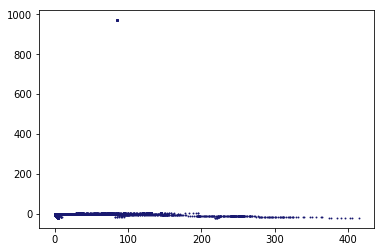

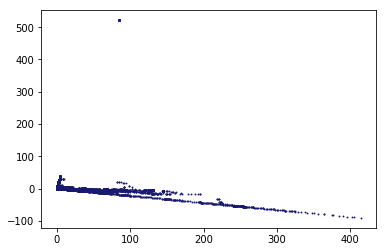

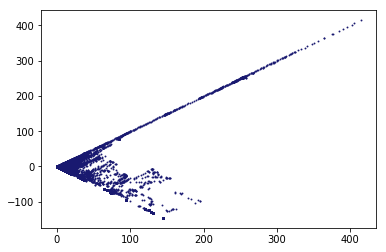

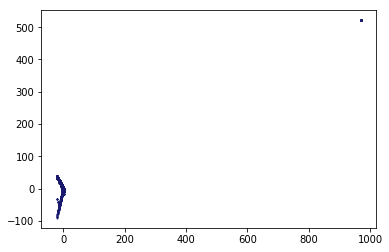

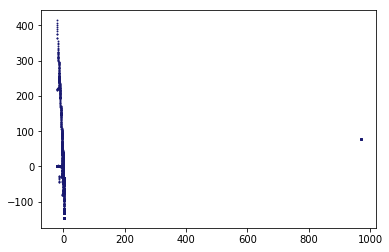

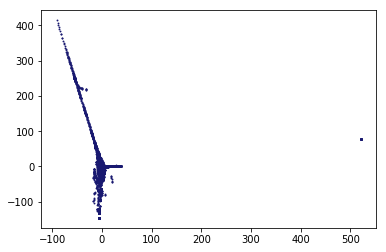

In [46]:
dp.printScatter(principalDf['pc1'], principalDf['pc2'])
dp.printScatter(principalDf['pc1'], principalDf['pc3'])
dp.printScatter(principalDf['pc1'], principalDf['pc4'])
dp.printScatter(principalDf['pc2'], principalDf['pc3'])
dp.printScatter(principalDf['pc2'], principalDf['pc4'])
dp.printScatter(principalDf['pc3'], principalDf['pc4'])

In [30]:
titles = principalDf.columns.tolist()
principalDf.describe()

,pc1,pc2,pc3,pc4
count,5.035843e+07,5.035843e+07,5.035843e+07,5.035843e+07
mean,-4.668113e-09,-3.874387e-08,1.293220e-09,1.143536e-09
std,1.023880e+00,1.000089e+00,9.997113e-01,9.757398e-01
min,-7.548344e-02,-2.137587e+01,-9.118384e+01,-1.460042e+02
25%,-5.851962e-02,2.251791e-02,-1.867476e-01,1.568554e-02
50%,-5.151653e-02,7.289623e-02,-1.324699e-01,1.991526e-02
75%,-3.724875e-02,1.029766e-01,-4.153235e-02,2.615462e-02
max,4.145098e+02,9.708786e+02,5.216219e+02,4.148745e+02


In [31]:
del principalDf
gc.collect()

21

In [32]:
X.dtype

dtype('float64')

In [33]:
X = X.astype('float32')

## 1 Gaussian Mixture Model

https://scikit-learn.org/stable/unsupervised_learning.html


In [30]:
"""n_components_range = range(1, 7)
best_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range)"""

'n_components_range = range(1, 7)\nbest_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range)'

In [31]:
"""bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange', 'gold', 'tomato'])
dp.plotBICScores(bic, cv_types, color_iter, n_components_range)"""

"bic = np.array(bic)\ncolor_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',\n                              'darkorange', 'gold', 'tomato'])\ndp.plotBICScores(bic, cv_types, color_iter, n_components_range)"

In [38]:
gmm = GaussianMixture(n_components=6, covariance_type='full')
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=6, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [39]:
gmm2 = GaussianMixture(n_components=5, covariance_type='full')
gmm2.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [40]:
gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=6, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [41]:
gmm.bic(X)

-1654005377.3045177

In [42]:
gmm2.bic(X)

-1653352827.4699614

In [43]:
best_gmm=gmm


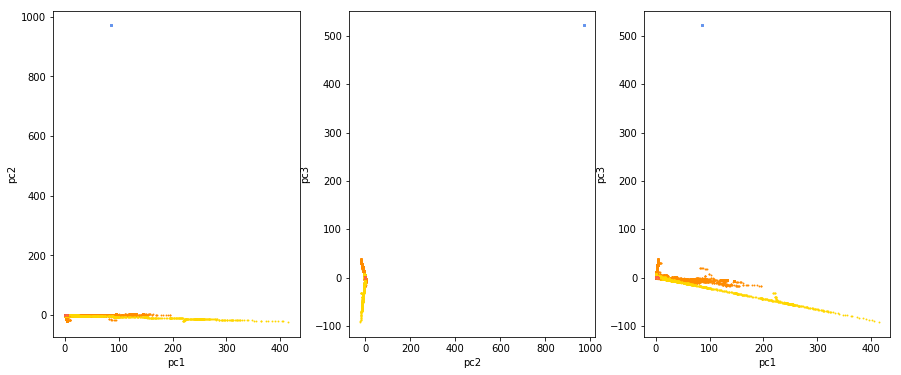

In [44]:
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange', 'gold', 'tomato'])
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.getPlotGMM(best_gmm, X, color_iter, 0, 1, ax[0], titles)
dp.getPlotGMM(best_gmm, X, color_iter, 1, 2, ax[1], titles)
dp.getPlotGMM(best_gmm, X, color_iter, 0, 2, ax[2], titles)
plt.show()
fig.clf()
plt.close()

In [45]:
hp.getRepresentativeness(best_gmm, X, best_gmm.predict(X))

{'>50': 1, '>30': 0, '>15': 0, '<15': 5}


[{'group': 0, 'qty': 42639778, 'representativeness': 0.846725755617312},
 {'group': 1, 'qty': 3929257, 'representativeness': 0.07802580731868755},
 {'group': 2, 'qty': 41, 'representativeness': 8.141636192456206e-07},
 {'group': 3, 'qty': 160223, 'representativeness': 0.003181652135765636},
 {'group': 4, 'qty': 44441, 'representativeness': 0.0008824937903145031},
 {'group': 5, 'qty': 3584688, 'representativeness': 0.07118347697430111}]

In [46]:
del best_gmm

## 2 K-Means

[4, 5, 6] components

In [ ]:
Y_, km = cl.getKmeanskClusters(4, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
del km, Y_
plt.clf()
plt.close()

In [ ]:
Y_, km = cl.getKmeanskClusters(5, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
del km, Y_
plt.clf()
plt.close()

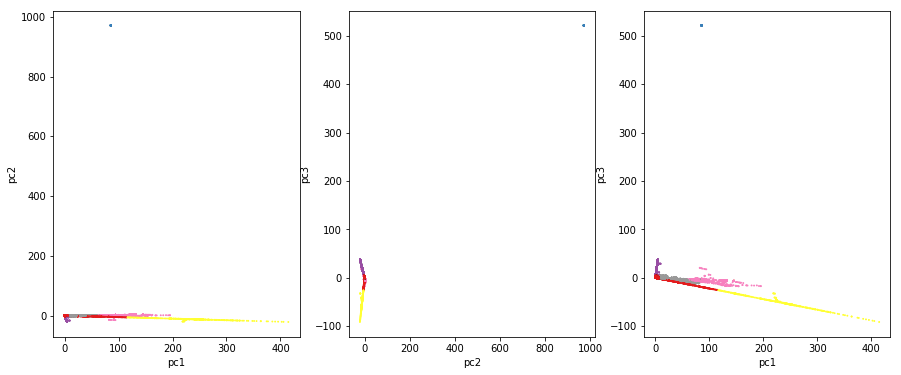

{'>50': 1, '>30': 0, '>15': 0, '<15': 5}
[{'group': 0, 'qty': 50180626, 'representativeness': 0.9964692702480705}, {'group': 1, 'qty': 41, 'representativeness': 8.141636192456206e-07}, {'group': 2, 'qty': 143041, 'representativeness': 0.0028404580063539713}, {'group': 3, 'qty': 379, 'representativeness': 7.526049065709517e-06}, {'group': 4, 'qty': 1491, 'representativeness': 2.960775503159074e-05}, {'group': 5, 'qty': 32850, 'representativeness': 0.0006523237778589912}]


In [34]:
Y_, km = cl.getKmeanskClusters(6, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
del km, Y_
plt.clf()
plt.close()

## 3 Mean Shift
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

> Bandwidth is not very different with quantity of samples 50000 or 100000, so for ease of computation, we will use 50000.
> 
> Quantile, it increases  the value of the bandwith, 0.3, gets 1.76 with 7 components, 0.5, gets 2.26 with 4 components

In [35]:
bandwidth = estimate_bandwidth(X, n_samples=50000, quantile=0.3)
bandwidth

0.26724108956958187

In [ ]:
bandwidth2 = estimate_bandwidth(X, n_samples=50000, quantile=0.5)
bandwidth2

In [36]:
bandwidth3 = estimate_bandwidth(X, n_samples=50000, quantile=0.7)
bandwidth3

0.36711622192382815

In [ ]:
bandwidth4 = estimate_bandwidth(X, n_samples=50000, quantile=0.2)
bandwidth4

number of estimated clusters : 3421
{'>50': 1, '>30': 0, '>15': 0, '<15': 3421}
[{'group': 0, 'qty': 48140734, 'representativeness': 0.9559618104044074}, {'group': 1, 'qty': 303536, 'representativeness': 0.006027511422715578}, {'group': 2, 'qty': 436380, 'representativeness': 0.008665480979668388}, {'group': 3, 'qty': 164968, 'representativeness': 0.0032758766814563792}, {'group': 4, 'qty': 144059, 'representativeness': 0.0028606730932903626}, {'group': 5, 'qty': 35826, 'representativeness': 0.0007114201420266732}, {'group': 6, 'qty': 31100, 'representativeness': 0.000617572891671678}, {'group': 7, 'qty': 16592, 'representativeness': 0.00032947811635422776}, {'group': 8, 'qty': 11252, 'representativeness': 0.00022343826935979812}, {'group': 9, 'qty': 12406, 'representativeness': 0.00024635399659417485}, {'group': 10, 'qty': 8586, 'representativeness': 0.00017049777645958289}, {'group': 11, 'qty': 3600, 'representativeness': 7.148753729961547e-05}, {'group': 12, 'qty': 2717, 'representa

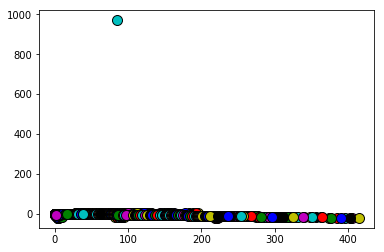

In [ ]:
ms, n_clusters_, cluster_centers, labels = cl.meanClustering(X, bandwidth)
print(hp.getRepresentativenessKM(ms, X, ms.predict(X)))
dp.plotMSh(X, ms, n_clusters_, cluster_centers, labels)

In [ ]:
ms1, n_clusters_1, cluster_centers1, labels1 = cl.meanClustering(X, bandwidth3)
print(hp.getRepresentativenessKM(ms1, X, ms1.predict(X)))
dp.plotMSh(X, ms1, n_clusters_1, cluster_centers1, labels1)

## 4 Variational Bayesian Gaussian Mixture

Having 5 components, changig the n_init, it has a better distribution in "representativeness" with a value of 2 and max_iter = 200

In [ ]:
dpgmm1 = BayesianGaussianMixture(n_components=5,
                                max_iter=200, n_init=2,
                                covariance_type='full').fit(X)
#print(dpgmm1.means_)
#print(dpgmm1.covariances_)
Y_ = dpgmm1.predict(X)
print(hp.getRepresentativeness(dpgmm1, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

In [ ]:
dpgmm3 = BayesianGaussianMixture(n_components=4,
                                max_iter=200, n_init=2,
                                covariance_type='full').fit(X)
#print(dpgmm3.means_)
#print(dpgmm3.covariances_)
Y_ = dpgmm3.predict(X)
print(hp.getRepresentativeness(dpgmm3, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

In [ ]:
# modify n_jobs maybe???,,